<a href="https://colab.research.google.com/github/akhilmhdh/facial-keypoint-recognition/blob/master/Facial_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google colab mounting
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!git clone https://github.com/akhilmhdh/facial-keypoint-recognition.git

Cloning into 'facial-keypoint-recognition'...
remote: Enumerating objects: 5787, done.
remote: Total 5787 (delta 0), reused 0 (delta 0), pack-reused 5787
Receiving objects: 100% (5787/5787), 322.00 MiB | 57.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (5786/5786), done.


In [0]:
root_url="/content/facial-keypoint-recognition/data"

# Importing Necessary Libraries

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import cv2


(136,)


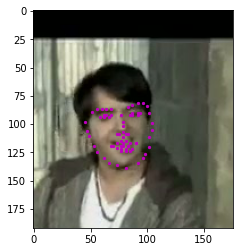

In [0]:
key_points=pd.read_csv(os.path.join(root_url,"training_frames_keypoints.csv"))

image_name = key_points.iloc[0, 0]
key_pts = key_points.iloc[0, 1:].to_numpy()
print(key_pts.shape)
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure()
img=Image.open(os.path.join(root_url,'training/', image_name))
plt.imshow(np.array(img))
plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

# Custom Dataset

In [0]:
from torch.utils.data import Dataset,DataLoader

class FacialKeypoints(Dataset):
  def __init__(self,csv_file,root_dir,transform=None):
    self.key_points_frame=pd.read_csv(csv_file)
    self.root_dir=root_dir
    self.transform=transform
  
  def __len__(self):
    return len(self.key_points_frame)
  
  def __getitem__(self,idx):
    img_name=os.path.join(self.root_dir,self.key_points_frame.iloc[idx,0])
    image=np.array(Image.open(img_name))

    # remove alpha channel
    if(image.shape[2] == 4):
      image=image[:,:,0:3]
    
    key_point=self.key_points_frame.iloc[idx,1:].to_numpy()
    key_point=key_point.astype('float').reshape(-1,2)
    sample={'image':image,'keypoints':key_point}

    if self.transform:
      sample=self.transform(sample)

    return sample



# Custom Transform

In [0]:
class Rescale(object):
  def __init__(self,output_size):
    assert isinstance(output_size,(int,tuple))
    self.output_size = output_size
  
  def __call__(self,sample):
    image,key_points = sample['image'],sample['keypoints']
    h,w = image.shape[:2]
    if isinstance(self.output_size,int):
      if h > w:
        new_h, new_w = self.output_size* h/w,self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w/h
    else:
      new_h, new_w = self.output_size
    
    new_h, new_w = int(new_h),int(new_w)

    img=cv2.resize(image,(new_w,new_h))

    key_points = key_points * [new_w/w, new_h/h]

    return {'image':img,'keypoints':key_points}
    

In [0]:
class RandomCrop(object):
  def __init__(self,output_size):
    assert isinstance(output_size,(int,tuple))
    if isinstance(output_size,int):
      self.output_size = (output_size,output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size
    
  def __call__(self,sample):
    image,key_points=sample['image'],sample['keypoints']
    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,left: left + new_w]

    key_points=key_points - [left,top]

    return {'image':image, 'keypoints':key_points}

    

In [0]:
class ToTensor(object):
  def __call__(self,sample):
    image,key_points=sample['image'],sample['keypoints']

    if(len(image.shape) == 2):
      image=image.reshape(image.shape[0],image.shape[1],1)
    
    image = image.transpose((2,0,1))

    return  {'image':torch.from_numpy(image), 'keypoints':torch.from_numpy(key_points)}

In [0]:
class Normalize(object):
  def __call__(self,sample):
    image,key_points = sample['image'], sample['keypoints']

    image_grey=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image_grey=image_grey/255.0

    key_points=(key_points-100)/50.0

    return {'image':image_grey, 'keypoints':key_points}


In [0]:
data_transform=transforms.Compose([Rescale(250),
                                RandomCrop(224),
                                Normalize(),
                                ToTensor()
                                ])


In [0]:
train_dataset=FacialKeypoints(root_dir=os.path.join(root_url,"training"),
                                 csv_file=os.path.join(root_url,"training_frames_keypoints.csv"),
                              transform=data_transform)

test_dataset=FacialKeypoints(root_dir=os.path.join(root_url,"test"),
                                 csv_file=os.path.join(root_url,"test_frames_keypoints.csv"),
                              transform=data_transform)

print("lenth:train dataset: ",len(train_dataset))
print("lenth:test dataset: ",len(test_dataset))

sample=train_dataset[0]
print(sample['image'].shape,sample['keypoints'].shape)

lenth:train dataset:  3462
lenth:test dataset:  770
torch.Size([1, 224, 224]) torch.Size([68, 2])


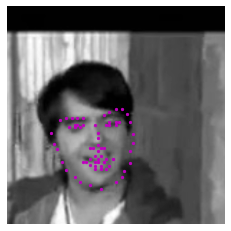

In [0]:
image=sample['image']
output=sample['keypoints']
image=image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
output_pts = output.view(68, -1)
prediction = output_pts.data.cpu().numpy()
prediction = prediction*50.0+100
plt.imshow(np.squeeze(image),cmap="gray")
plt.scatter(prediction[:, 0], prediction[:, 1], s=20, marker='.', c='m')
plt.axis('off')
plt.show()

In [0]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=4)

test_loader= DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=4)

# Model Structure

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # conv layer
    self.conv1=nn.Conv2d(1,32,3,padding=1)
    self.conv2=nn.Conv2d(32,64,3,padding=1)
    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.conv4=nn.Conv2d(128,128,3,padding=1)
    self.conv5=nn.Conv2d(128,256,3,padding=1)
    self.conv6=nn.Conv2d(256,256,3,padding=1)
    self.conv7=nn.Conv2d(256,512,3,padding=1)
    self.conv8=nn.Conv2d(512,512,3,padding=1)
    # pooling layer
    self.pool = nn.MaxPool2d(2,2)
    # dropout layers
    self.dropout = nn.Dropout(0.5)
    # linear layer
    self.fc1=nn.Linear(512*14*14,4096)
    self.fc2=nn.Linear(4096,1024)
    self.fc3=nn.Linear(1024,136)
    # batch normalization
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.bn4 = nn.BatchNorm2d(num_features=128)
    self.bn5 = nn.BatchNorm2d(num_features=256)
    self.bn6 = nn.BatchNorm2d(num_features=256)
    self.bn7 = nn.BatchNorm2d(num_features=512)
    self.bn8 = nn.BatchNorm2d(num_features=512)
    self.bn9 = nn.BatchNorm1d(num_features=4096)
    self.bn10 = nn.BatchNorm1d(num_features=1024)

  def forward(self,x):
    x=self.bn1(F.relu(self.conv1(x)))
    x=self.pool(self.bn2(F.relu(self.conv2(x))))
    x=self.bn3(F.relu(self.conv3(x)))
    x=self.pool(self.bn4(F.relu(self.conv4(x))))
    x=self.bn5(F.relu(self.conv5(x)))
    x=self.pool(self.bn6(F.relu(self.conv6(x))))
    x=self.bn7(F.relu(self.conv7(x)))
    x=self.pool(self.bn8(F.relu(self.conv8(x))))
    # flatten fc layer begins
    x=x.view(-1,512*14*14)
    x=self.dropout(x)
    x=self.dropout(self.bn9(F.relu(self.fc1(x))))
    x=self.dropout(self.bn10(F.relu(self.fc2(x))))
    x=self.fc3(x)
    return x

# Loss function

In [7]:
train_on_gpu= torch.cuda.is_available()

model = Net()

if train_on_gpu:
    model.cuda()

print(train_on_gpu)


False


In [0]:
criterion = nn.MSELoss()

optimizer=optim.Adam(model.parameters(),lr=0.001)

# Train Function

In [0]:
def train(epochs,model,valid_loss_min):
  for epoch in range(1,epochs+1):
    train_loss=0.0
    valid_loss=0.0

    model.train()

    for batch, data in enumerate(train_loader):
      images,key_points = data['image'], data['keypoints']

      key_points = key_points.view(key_points.size(0),-1)

      key_points=key_points.type(torch.FloatTensor)
      images=images.type(torch.FloatTensor)

      if train_on_gpu:
        images,key_points=images.cuda(),key_points.cuda()

      optimizer.zero_grad()

      output=model(images)

      loss=criterion(output,key_points)

      loss.backward()

      optimizer.step()

      train_loss+=loss.item()*images.size(0)
    
    model.eval()
    with torch.no_grad():
      for batch, data in enumerate(test_loader):
        images,key_points = data['image'], data['keypoints']

        key_points = key_points.view(key_points.size(0),-1)

        key_points=key_points.type(torch.FloatTensor)
        images=images.type(torch.FloatTensor)

        if train_on_gpu:
          images,key_points=images.cuda(),key_points.cuda()

        output=model(images)

        loss=criterion(output,key_points)

        valid_loss+=loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)

    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss<=valid_loss_min:
       print('Model Save ({:.6f} --> {:.6f})'.format(valid_loss_min,valid_loss))
       torch.save({
           "model":model.state_dict(),
           "valid_loss_min":valid_loss
       },os.path.join("/content/gdrive/My Drive/Colab Notebooks/facial-keypoints/data/save",'facial_keypoints.pt'))
       valid_loss_min=valid_loss



In [0]:
# loadFileName = "/content/gdrive/My Drive/Colab Notebooks/facial-keypoints/data/save/facial_keypoints.pt"
loadFileName=None
valid_loss_min=np.inf

if loadFileName:
  savedState=torch.load(loadFileName)
  modelDict=savedState["model"]
  model.load_state_dict(modelDict)
  valid_loss_min=savedState["valid_loss_min"]

epochs=20

train(epochs=epochs,model=model,valid_loss_min=valid_loss_min)


Epoch: 1 	 Training Loss: 0.367062 	 Validation Loss: 0.158652
Model Save (inf --> 0.158652)
Epoch: 2 	 Training Loss: 0.221624 	 Validation Loss: 0.156012
Model Save (0.158652 --> 0.156012)
Epoch: 3 	 Training Loss: 0.182129 	 Validation Loss: 0.100372
Model Save (0.156012 --> 0.100372)
Epoch: 4 	 Training Loss: 0.136675 	 Validation Loss: 0.090531
Model Save (0.100372 --> 0.090531)
Epoch: 5 	 Training Loss: 0.112730 	 Validation Loss: 0.074395
Model Save (0.090531 --> 0.074395)
Epoch: 6 	 Training Loss: 0.106410 	 Validation Loss: 0.136165
Epoch: 7 	 Training Loss: 0.096976 	 Validation Loss: 0.060585
Model Save (0.074395 --> 0.060585)
Epoch: 8 	 Training Loss: 0.101236 	 Validation Loss: 0.090772
Epoch: 9 	 Training Loss: 0.087028 	 Validation Loss: 0.105590
Epoch: 10 	 Training Loss: 0.093269 	 Validation Loss: 1.757115
Epoch: 11 	 Training Loss: 0.115918 	 Validation Loss: 0.212140
Epoch: 12 	 Training Loss: 0.094765 	 Validation Loss: 1.622376
Epoch: 13 	 Training Loss: 0.081150 

# Testing

In [0]:
def img_transform(img, output_size=224):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img / 255.0    
    img = cv2.resize(img, (output_size, output_size))    
    img_tensor=torch.from_numpy(img.reshape(1,1,output_size,output_size))  
    img_tensor = img_tensor.type(torch.FloatTensor)
    return img, img_tensor


In [0]:
loadFileName = "/content/gdrive/My Drive/Colab Notebooks/facial-keypoints/data/save/facial_keypoints.pt"

if loadFileName:
  savedState=torch.load(loadFileName ,map_location=lambda storage, loc: storage)
  modelDict=savedState["model"]
  model.load_state_dict(modelDict)
  valid_loss_min=savedState["valid_loss_min"]



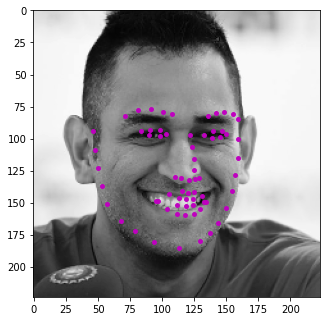

In [21]:
model.eval()
model.to('cpu')
image = cv2.imread('/content/dhoni.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=2)

pad_scale=0.33

f = plt.figure(figsize=(36,36))
for i,(x,y,w,h) in enumerate(faces):
    ax = f.add_subplot(2, 6, i+1)
    wpad = int(w*pad_scale)
    hpad = int(h*pad_scale)
    face_img = image[y-hpad:y+h+hpad, x-wpad:x+w+wpad]
    face_img_norm, face_img_tensor = img_transform(face_img)
    output_pts = model(face_img_tensor)
    torch.squeeze(output_pts)       
    output_pts = output_pts.view(68, -1)
    predicted_key_pts = output_pts.data.cpu().numpy()
    predicted_key_pts = predicted_key_pts*50.0+100
    plt.imshow(face_img_norm, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=60, marker='.', c='m')

plt.show()

In [0]:
|